Comments:  The transformation of AffectVec vectors into graphs is done by pursueing nearest neighbor links.
This is okay but involves a lot of arbitrary decisions.  A more principled approach for
that transformation is to use the Newman $A^{n}$ generator, which goes the other wya,
and reverse.  The Newman Method starts with  $A$, the adjacency matrix of a graph; it turns out
$A^{i}$ contains the number paths of length i between any two nodes.  The result
in the limit gives a pretty plausible set of word vectors.  This has been done for WordNet (see ??).

It can be done backward to go from the vectors to the graph.

Start with $S= MM^{T}$, a sort of similarity matrix constructed form the word vector matrix M.
This can be viewed as a weighted adjacency matrix for a graoh.
It's little unusable because every word is directly connected to every other by some weight,
so we need do some threshholdding and pruning.

I already know that $S= MM^{T}$ is computationally intractable on my machine ($80,000^2$ is a LOT of
of floating point numbers).  So we start with a mini. lexicon


In [35]:
import time


from heapq import heappush, heappushpop, heappop
#Only needed if using ic
#from nltk.corpus import wordnet as wn

import numpy as np
import sklearn
import sklearn.decomposition as dec
#import sklearn.manifold as man
#from sklearn import linear_model
#from sklearn.metrics import accuracy_score, recall_score, precision_score
#import sklearn.datasets 
#import matplotlib.pyplot as plt
#from sklearn.metrics.pairwise import euclidean_distances#cosine_similarity
import scipy
from datetime import datetime
##  Use np.linalg.matrix_rank instead
## matrixM  is Full rank iff M is linearly independent
#import sympy


#from filter_vecs import dimensionality_strength


def find_nearest_n (center, n, sim_func, wvecs, wd2idx,  words, ic=None,
                    preserve_pos=False, pos = None):
    """
    Find nearest C{n} neighbors of the word C{center} in C{wvecs}.
    C{wvecs} is any container with a
    set of objects whose distance can be measured using C{sim_func}.

    Currently not using  ic or wn as in this commented out line in the code below.

    #score2 = wn.jcn_similarity(center, lexeme, ic)

    C{deprel_dict} contains vectors for C{center} and objects in C{search_space} that can be used for the
    C{sim_func} computation.
    """
    #print("entering find_nearest_n")
    neighbors = []
    if n == 0:
        return neighbors
    heap_len = 0
    # heap_min = 0
    if pos:
        this_pos = pos
    elif preserve_pos:
        word, this_pos = center.name(), center.pos()
    else:
        this_pos = None

    #center_vec = wv.word_vec(center)
    center_vec = wvecs[wd2idx[center],:]
    for lexeme in  words:
        if lexeme == center:
            continue
        elif this_pos:
            (word_i,pos_i) = lexeme.name(),lexeme.pos()
            if pos_i != this_pos:
                continue
        #lexeme_vec = hv.word_vec(lexeme)
        lexeme_vec = wvecs[wd2idx[lexeme],:]
        score  = sim_func(center_vec, lexeme_vec)
        #score2 = wn.jcn_similarity(center, lexeme, ic)
        if heap_len < n:
            heappush(neighbors,(score, lexeme))
            heap_len += 1
            # if score > heap_min:
            #    pass
            # else:
            #    heap_min = score
        else:
            #if score > heap_min:
            #    ## Using replace rather than pushpop  because neighbors cant be empty
            #    heapreplace(neighbors,(score,lexeme))
            #    ## Reset min.
            #    (heap_min, min_lex) = heappop(neighbors)
            #    heappush(neighbors,(heap_min,min_lex))
            heappushpop(neighbors, (score,lexeme))
    return [heappop(neighbors) for i in range(n)]

def find_nearest_n_vec (center_vec, n, wvecs,words, sim_func,cob=None):
    """
    Find n nearest neighbors of vec in wvecs (a collection
    of like-minded vectors).  Use similarity function sim_func.

    cob is an optional change of basis.
    """
    neighbors = []
    if n == 0:
        return neighbors
    heap_len = 0
    for lexeme in words:
        #for lexeme_vec in  wvecs:
        lexeme_vec = wvecs[word2idx[lexeme],:]
        if cob is not None:
            lexeme_vec = cob@lexeme_vec
        score  = sim_func(center_vec, lexeme_vec)
        #score2 = wn.jcn_similarity(center, lexeme, ic)
        if heap_len < n:
            heappush(neighbors,(score, lexeme))
            heap_len += 1
        else:
            heappushpop(neighbors, (score,lexeme))
    return [heappop(neighbors) for i in range(n)]

def my_cos(v1,v2):
    return v1.dot(v2)/(np.linalg.norm(v1)*np.linalg.norm(v2))

#def core_similarity (wd):
#    return sum(my_cos(wvecs[word2idx[wd],:], wvecs[word2idx[cw],:])
#               for cw in core_words)


def information_lost(X, X_reduced, transformer):
    """
    Meaasure the amount of information lost by the transformer.

    Reverse the transformation and look at the difference matrix gotten
    by subtracting X_reduced reverse-transformed from X. In the ideal
    case of no information lost this difference should be 0.

    Compare the frobenius norm  (a kind of length
    measure for matrices) of the difference matrix to the frobenius norm of X.
    """
    return scipy.linalg.norm(X - transformer.inverse_transform(X_reduced),ord="fro")


def percent_information_loss(X, loss):
    return loss/scipy.linalg.norm(X,ord="fro")



def prepare_dimensionality_loss_data(data,threshhold=50):
    """
    To demonstrate that about 1/2 the dimensions preserve about
    90% of the information.  The loss however is interpretability
    of the dimensions.
    """
    Loss_vec = np.empty((threshhold,))
    for i in range(1,threshhold+1):
        reducer_svd = dec.TruncatedSVD(n_components=i)
        data_reduced = reducer_svd.fit_transform(data)
        loss = information_lost(data, data_reduced, reducer_svd)
        Loss_vec[i-1] = loss
        pct_loss = percent_information_loss(data, loss)
        print(f"{i}-demension model {loss:.3f} {pct_loss:.2%}")
    return np.arange(1,threshhold+1), Loss_vec

def construct_dimensions_matrix(wvecs,word2idx,categories):
    d=len(categories)
    M = np.empty((d,d))
    #M=[]
    for (i,cat) in enumerate(categories):
        M[:,i] = wvecs[word2idx[cat],:]
    #M.append( wvecs[word2idx[cat],:])
    return M.T
    #return np.array([wvecs[word2idx[cat],:] for cat in categories]).T

def check_symmetric(a, rtol=1e-05, atol=1e-08):
    return np.allclose(a, a.T, rtol=rtol, atol=atol)


In [3]:
import read_write_vecs

loading_vecs=True
if loading_vecs:
    
    ####  Data paths ########################
    path = "AffectVec-data.txt"
    binary_path= "wvecs.npy"
    words_path = "vocab.txt"
    categories_path = "emotion_categories.txt"
    ####  End Data paths ######################

    #start = time.time()
    #words, wvecs = read_vecs(path)
    #end = time.time()
    #print(f"Read vecs in in {end-start} secs")
    #write_binary(wvecs)
    #write_binary_n(wvecs)


    start = time.time()
    #wvecs= read_binary (fn="wvecs.dat")
    wvecs = read_write_vecs.read_binary_n (fn=binary_path)
    words = read_write_vecs.read_words(words_path)
    categories = read_write_vecs.read_categories(categories_path)
    #words, wvecs = read_vecs (path)
    end = time.time()
    V,D = wvecs.shape
    print(f"Read binary vecs and word in in {end-start} secs V {V} D {D}")
    word2idx = read_write_vecs.make_encoding_dict (words)
  
    #cat2idx = {cat:idx for (idx,cat) in enumerate(categories)}
    cat2idx = read_write_vecs.make_encoding_dict (categories)


Read binary vecs and word in in 0.10915517807006836 secs V 76427 D 239


In [39]:
wvecs.shape

(76427, 239)

In [36]:
fun_nns = find_nearest_n ("fun", 20, my_cos, wvecs, word2idx,words)
for (sc,wd) in fun_nns[::-1]:
    print(f"{wd:<25} {sc:.3f}")


amusing                   0.997
entertaining              0.990
funny                     0.977
laugh                     0.976
laughing                  0.976
entertainment             0.976
amusement                 0.974
enjoyable                 0.974
laughs                    0.974
pleasurable               0.971
laughter                  0.968
pleasant                  0.967
giggling                  0.964
entertained               0.963
pleasures                 0.963
humorous                  0.963
pleasing                  0.961
smile                     0.960
entertain                 0.960
gratifying                0.958


In [37]:

pleasurable_nns = find_nearest_n ("pleasurable", 20, my_cos, wvecs, word2idx,words)
for (sc,wd) in pleasurable_nns[::-1]:
    print(f"{wd:<25} {sc:.3f}")



enjoyable                 1.000
pleasant                  0.997
pleasing                  0.993
agreeable                 0.991
gratifying                0.990
nice                      0.978
satisfying                0.977
satisfactory              0.973
fun                       0.971
heartening                0.968
palatable                 0.966
leisurely                 0.965
happiest                  0.964
amusing                   0.963
enjoying                  0.963
enjoy                     0.963
delightful                0.962
tasty                     0.961
charming                  0.960
delighted                 0.960


They're pointing in exactly the same direction; they differ in that one is a smidgeon shorter than the
other.

In [144]:
pleasurable_vec = wvecs[word2idx["pleasurable"]]
enjoyable_vec = wvecs[word2idx["enjoyable"]]
print(np.linalg.norm(pleasurable_vec)-np.linalg.norm(enjoyable_vec))

0.020693655591082383


Plutchik's wheel of emotion words.  Note the absence of "love" and "hate".  Plutchik regards these as complicated.  Maybe that much is right.  In any case, he places "love" on the wheel in the white space between "joy"
and "trust" and a lot of the literature on the psychology of emotions seems to agree with him in
not calling love basic.

In [5]:
#Words from plutchik's wheel.  First basic emotions
basic_emotions  = "anger,anticipation,joy,trust,fear,surprise,sadness,disgust".split(",")
# more intense than basic
basic_emotions += "rage,vigilance,ecstasy,admiration,terror,amazement,grief,loathing".split(",")
# less intense than  basic
basic_emotions += "annoyance,interest,serenity,acceptance,apprehension,distraction,pensiveness,boredom".split(",")
# not from plutchik, just for good measure
basic_emotions += "asshole,damn,whee".split(",")
print(len(basic_emotions))
filtered_basic_emotions = [emotion for emotion in basic_emotions if emotion in words]
print(len(filtered_basic_emotions))

27
26


This guy has to be dropped because he has no word vector.

In [136]:
"pensiveness" in words

False

In [6]:
import networkx as nx


def add_nns(emotion,g,n=20,recurse=0,verbose=False,shrink_fac=2):
    nn_scores = find_nearest_n (emotion, 
                          n, my_cos, wvecs, word2idx,words)
    nns = []
    for (score, word) in nn_scores[::-1]:
        nns.append(word)
        if (emotion,word) not in g.edges:
            g.add_edge(emotion,word,weight=score)
            if verbose and len(g)%100==0:
                print(f"g has {len(g)} nodes")
    if recurse:
        for nn in nns:
            add_nns(nn,g,n=n//shrink_fac,recurse=recurse-1,verbose=verbose)

In [7]:
        
g = nx.Graph()
for emotion in filtered_basic_emotions:
    print(f"NNs for {emotion}")
    add_nns(emotion,g,recurse=1,verbose=True)
                           
#emotion:find_nearest_n ("pleasurable", 20, my_cos, wvecs, word2idx,words) for emotion in basic_emotions}

NNs for anger
NNs for anticipation
g has 100 nodes
g has 100 nodes
g has 100 nodes
g has 100 nodes
g has 100 nodes
g has 100 nodes
NNs for joy
NNs for trust
g has 200 nodes
NNs for fear
NNs for surprise
g has 300 nodes
NNs for sadness
NNs for disgust
NNs for rage
NNs for vigilance
g has 400 nodes
NNs for ecstasy
g has 500 nodes
NNs for admiration
g has 600 nodes
NNs for terror
NNs for amazement
g has 700 nodes
g has 700 nodes
NNs for grief
NNs for loathing
NNs for annoyance
NNs for interest
g has 800 nodes
NNs for serenity
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
g has 900 nodes
NNs for acceptance
NNs for apprehension
g has 1000 nodes
NNs for distraction
NNs for boredom
g has 1100 nodes
NNs for asshole
g has 1200 nodes
g has 1200 nodes
g has 1200 nodes
g has 1200 nodes
g has 1200 nodes
g has 1200 nodes
g h

In [8]:
nx.is_connected(g)

False

There are 4 components

In [9]:
nx.number_connected_components(g)

4

In [10]:
len(g)

1347

In [11]:
list(g.neighbors("ire"))

['anger',
 'wrath',
 'fury',
 'rage',
 'angered',
 'outrage',
 'indignation',
 'irritation',
 'angry',
 'rabies',
 'cholera']

Find the word with highest degree in the graph:

In [12]:
degrees_g = dict(g.degree())
(wds,degs) = zip(*degrees_g.items())
degs = np.array(degs)
idxs = degs.argsort()
degs[idxs[-1]],wds[idxs[-1]]

(24, 'disgust')

In [14]:
list(g.neighbors("disgust"))

['anger',
 'wrath',
 'fury',
 'rage',
 'outrage',
 'indignation',
 'irritation',
 'loathing',
 'distaste',
 'revulsion',
 'aversion',
 'antipathy',
 'repugnance',
 'dislike',
 'exasperation',
 'repulsion',
 'disapproval',
 'displeasure',
 'resentment',
 'unpleasantness',
 'dissatisfaction',
 'discontent',
 'horror',
 'annoyance']

In [13]:
degrees_g["fear"]

20

Find the largest of the 4 compopnents (generally referred toas the "giant" compnent.

In [25]:
comps = sorted(nx.connected_components(g), key=len, reverse=True)[0]
comps = list(comps)
first = comps
first

['outraged',
 'monotony',
 'excitation',
 'grumbling',
 'climax',
 'look',
 'nausea',
 'glanced',
 'concentration',
 'disturb',
 'scandal',
 'feelings',
 'moans',
 'curses',
 'anticipation',
 'propensity',
 'impressive',
 'waited',
 'accepted',
 'hope',
 'nobility',
 'prestige',
 'assure',
 'gazed',
 'repulsion',
 'exclaim',
 'entertained',
 'muttered',
 'heroism',
 'loathes',
 'spontaneity',
 'admission',
 'stunned',
 'panic',
 'raptures',
 'agreeing',
 'superhuman',
 'abounds',
 'staggering',
 'sleeplessness',
 'cumming',
 'naturalness',
 'appreciation',
 'tinged',
 'novelty',
 'rancour',
 'scares',
 'grieved',
 'hesitations',
 'agitation',
 'longing',
 'heartbreak',
 'sexiness',
 'deliciousness',
 'cared',
 'unnerved',
 'primacy',
 'admirable',
 'endorsement',
 'presence',
 'delight',
 'awaits',
 'deplore',
 'fright',
 'infuriate',
 'chills',
 'pondering',
 'voyeuristic',
 'welcoming',
 'true',
 'negativity',
 'relevancy',
 'antipathy',
 'bemoan',
 'outlandish',
 'naughtiness',
 'al

In [26]:
len(first)

1134

Let's lop off this subgraph so we can do things with it.

In [27]:
gc = g.subgraph(first)

In [130]:
"fear" in gc

True

"serenity" is the only one of Plutchik wheel words not to show in the gc.

In [133]:
[e for e in filtered_basic_emotions if e not in gc]

['serenity', 'asshole', 'damn', 'whee']

The word with teh highrest degree in the graph

In [30]:
degrees_gc = dict(gc.degree())
(wds_gc,degs_gc) = zip(*degrees_gc.items())
degs_gc = np.array(degs_gc)
idxs_gc = degs_gc.argsort()
wds_gc = [wd for wd in wds if wd in gc]
degs_gc[idxs_gc[-1]],wds_gc[idxs_gc[-1]]

(24, 'disgust')

Structure of the gc graph (leaving out most node labels so as to be readable) reveals
the large component gc is actually held together by a collection of bridges.  

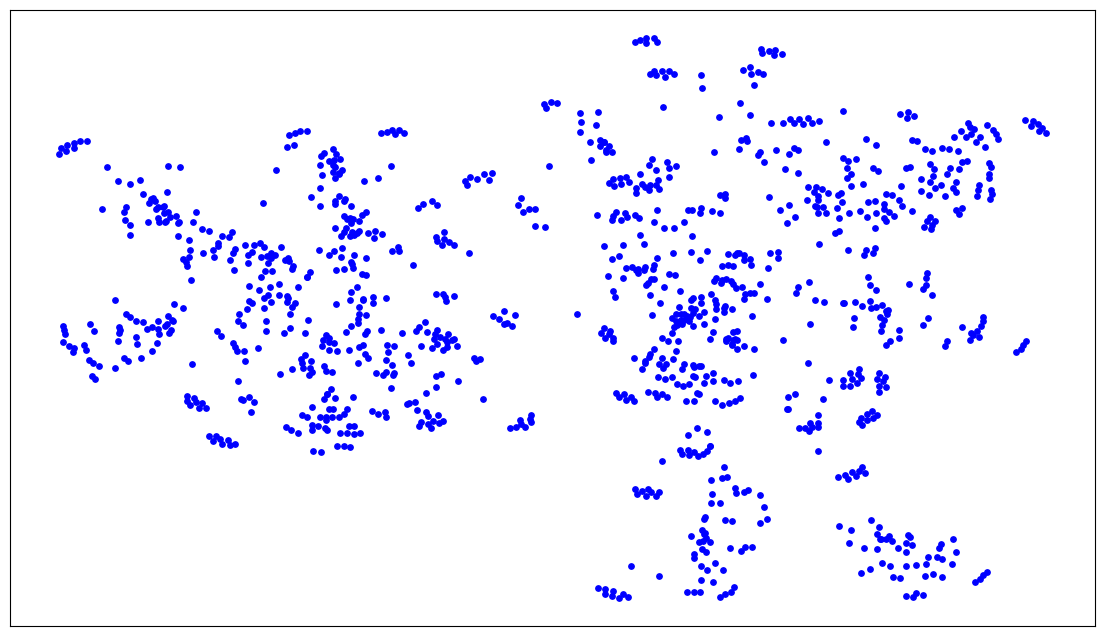

In [153]:
plt.figure(figsize=(14,8))
##############  Do Layout ########################################################
#pos=nx.spring_layout(gc,seed=8) 
pos_gc=nx.spring_layout(gc,seed=8) 
##############  Draw Edges ########################################################
#nx.draw_networkx_edges(lm,pos, edge_color='blue',alpha=.3)  
##############  Draw Small Unlabeled Nodes ########################################################
nx.draw_networkx_nodes(gc,pos,node_color='blue',node_size=15)#,edge_color="k") 
##############  Draw Large Labeled Nodes ########################################################
#ncoll= nx.draw_networkx_nodes(lm,pos,new_labels,node_color='red',node_size=200)
## Add outline to large nodes only
#ncoll.set_edgecolor('black')
new_labels = {n:n for n in gc}
# yoff: Raise labels so that text bottom is 9 pt above node bottom
#text = annotate_with_networkx_labels(gc,pos,labels=new_labels,yoff=7, alpha = .8, 
#                                     verticalalignment='bottom',fontsize=8)
#plt.savefig("AffectVec_joy_words.png")

Use betweennees centrality
to find some of teh words in the bridges:

In [71]:
#betweenness_centrality giant component
node_betweenness_gc = sorted(dict(nx.betweenness_centrality(gc)).items(),key=lambda x:x[1])
betweenness_words,between_scores=zip(*node_betweenness_gc)

These should be the bridge points (maybe Katz-centrality would work better?)

In [44]:
#max_iter = 1_000 # Default: PowerIterationFailedConvergence \Exception
#max_iter = 5_000 # Ditto
#max_iter = 10_000 # Troed reducing convergence cjheck tol from 1e-6 60 1e-5,  ditto
#kc_gc = sorted(dict(nx.katz_centrality(gc,max_iter=max_iter,tol=1.0e-5)).items(),key=lambda x:x[1])


Katz Centrality didnt converge in time.   Graph essentially too large? Or iteration
limit too small?  Anyway, tried page_rank

In [72]:
page_rank_data = sorted(dict(nx.pagerank(gc)).items(),key=lambda x:x[1])
page_rank_words,page_rank_scores = zip(*page_rank_data)


Despite its blue-blooded pedigree (Google!) page-rank generally correlates strongly with
degree centrality (in an undirected graph?).

In [70]:
degree_centrality_data = sorted(dict(nx.degree_centrality(gc)).items(),key=lambda x:x[1])
dc_words,dc_scores = zip(*degree_centrality_data)

In [108]:
dc_words[-20:]

('trust',
 'fear',
 'terror',
 'surprise',
 'sadness',
 'grief',
 'vigilance',
 'ecstasy',
 'admiration',
 'amazement',
 'interest',
 'acceptance',
 'apprehension',
 'distraction',
 'boredom',
 'anger',
 'joy',
 'annoyance',
 'loathing',
 'disgust')

In [87]:
import scipy.stats as scs

print(f"pearsonr: {scs.pearsonr(page_rank_scores,dc_scores)[0]:.3f}"
      f"   spearmanr: {scs.spearmanr(page_rank_scores,dc_scores)[0]:.3f}")

pearsonr: 0.979   spearmanr: 0.956


In [138]:
nodes_to_track

['anger',
 'anticipation',
 'joy',
 'trust',
 'fear',
 'surprise',
 'sadness',
 'disgust',
 'rage',
 'vigilance',
 'ecstasy',
 'admiration',
 'terror',
 'amazement',
 'grief',
 'loathing',
 'annoyance',
 'interest',
 'acceptance',
 'apprehension',
 'distraction',
 'boredom']

22


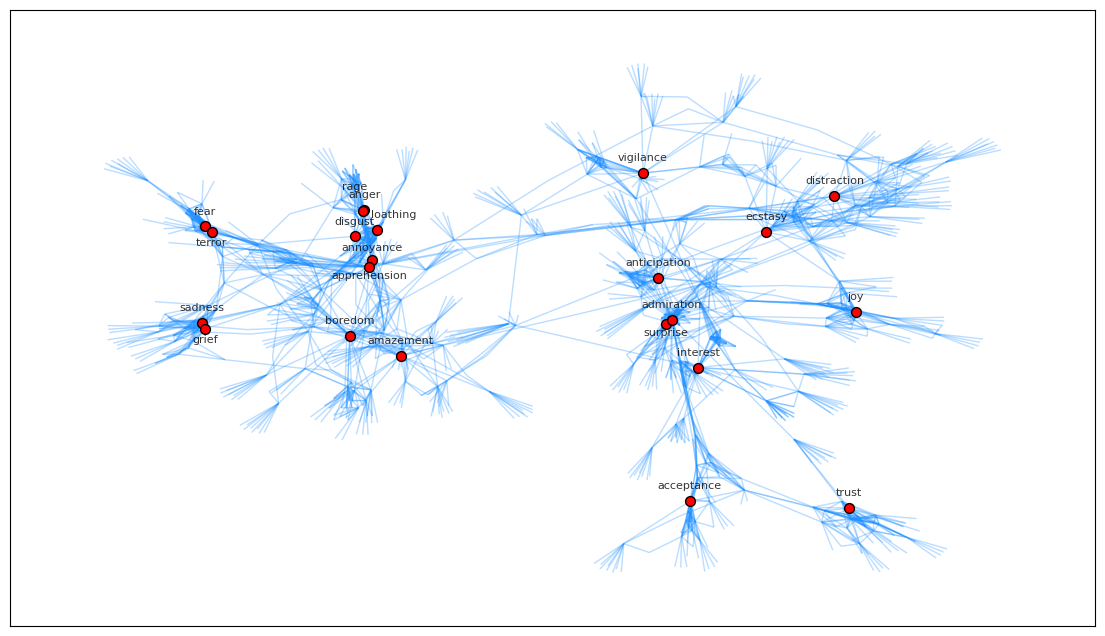

In [158]:
from matplotlib import pyplot as plt
import math

num_to_track = 20
#nodes_to_track = betweenness_words[-num_to_track:]
# Huge overlap with plutchhik words in gc (not suririsngly)
#nodes_to_track = dc_words[-num_to_track:]
nodes_to_track = [word for word in filtered_basic_emotions if word in gc]
print(len(nodes_to_track))
plt.figure(figsize=(14,8))
##############  Do Layout ########################################################
#pos_gc=nx.spring_layout(gc,seed=8) 
##############  Draw Edges ########################################################
nx.draw_networkx_edges(gc,pos_gc, edge_color='dodgerblue',alpha=.3)  
##############  Draw Small Unlabeled Nodes ########################################################
#node_colors = {node:"red" if node in betweenness_words else "blue" for node in gc.nodes}
node_colors = ["red" if node in nodes_to_track else "blue" for node in gc.nodes]
node_size = [50 if node in nodes_to_track else 20 for node in gc.nodes]
#nx.draw_networkx_nodes(gc,pos_gc,node_color='blue',node_size=20)#,edge_color="k") 
#nx.draw_networkx_nodes(gc,pos_gc,node_color=node_colors,node_size=node_size)#,edge_color="k") 

##############  Draw Large Labeled Nodes ########################################################
# Just draw the nodes to track over the edges
ncoll = nx.draw_networkx_nodes(gc,pos_gc,nodes_to_track,node_color="red",node_size=50)#,edge_color="k") 
#ncoll is a matplotlib path collection
ncoll.set_edgecolor("k")
new_labels = {n:n for n in nodes_to_track}
# yoff: Raise labels so that text bottom is yoff pt above node bottom
yoff = 7
# tweak positioning of node labels
#offset_dict = {n:(0,-8) if n == "apprehension" else (0,yoff) for n in nodes_to_track}
offset_dict = {"apprehension":(0,-10),"annoyance":(0,5),
               "surprise":(0,-10),"grief":(0,-12),"terror":(0,-12),
               "rage":(-6,14),"loathing":(12,yoff)}
text = annotate_with_networkx_labels(gc,pos_gc,labels=new_labels,alpha = .8, 
                                     offset_dict = offset_dict,yoff=yoff,
                                      verticalalignment='bottom',fontsize=8)
plt.savefig("AffectVec_plutchik_words_all.png")


Note there is a misspelled version of "ecstasy" and a correctly spelled one.   They are both betweenness words, but not vector synonyms!

In [183]:
#center, n, sim_func, wvecs, wd2idx,  words
ecstasy_vec = wvecs[word2idx["ecstasy"],:]
ecstacy_vec = wvecs[word2idx["ecstacy"],:]
print(my_cos(ecstasy_vec ,ecstacy_vec ))
ecstasy_nns = find_nearest_n("ecstasy",20,my_cos,wvecs, word2idx,  words)
ecstasy_scores,ecstasy_words = zip(*ecstasy_nns)
ecstacy_nns = find_nearest_n("ecstacy",20,my_cos,wvecs, word2idx,  words)
ecstacy_scores,ecstacy_words = zip(*ecstacy_nns)

0.8959116876682303


The drug seems to be predominantly associated with the correct spelling, which has also
got more sexual associations:

In [187]:
set(ecstasy_words) - set(ecstacy_words)

{'arousal',
 'awakening',
 'ecstacy',
 'elated',
 'elation',
 'endorphin',
 'endorphins',
 'euphoric',
 'exaltation',
 'excitation',
 'excitements',
 'mdma',
 'orgasmic',
 'orgasms',
 'rapture',
 'rapturous',
 'reveille',
 'thrills'}

In [188]:
#ecstacy_words
set(ecstacy_words) - set(ecstasy_words)

{'awaking',
 'coursing',
 'crescendo',
 'delirious',
 'delirium',
 'drunkenness',
 'ecstasies',
 'ecstasy',
 'giddiness',
 'hallucination',
 'horniness',
 'inebriation',
 'relived',
 'reliving',
 'reverie',
 'squeals',
 'throb',
 'throbs'}

Whether there's a new word emergbing here or not depedns on frequency info we haven't got.

20


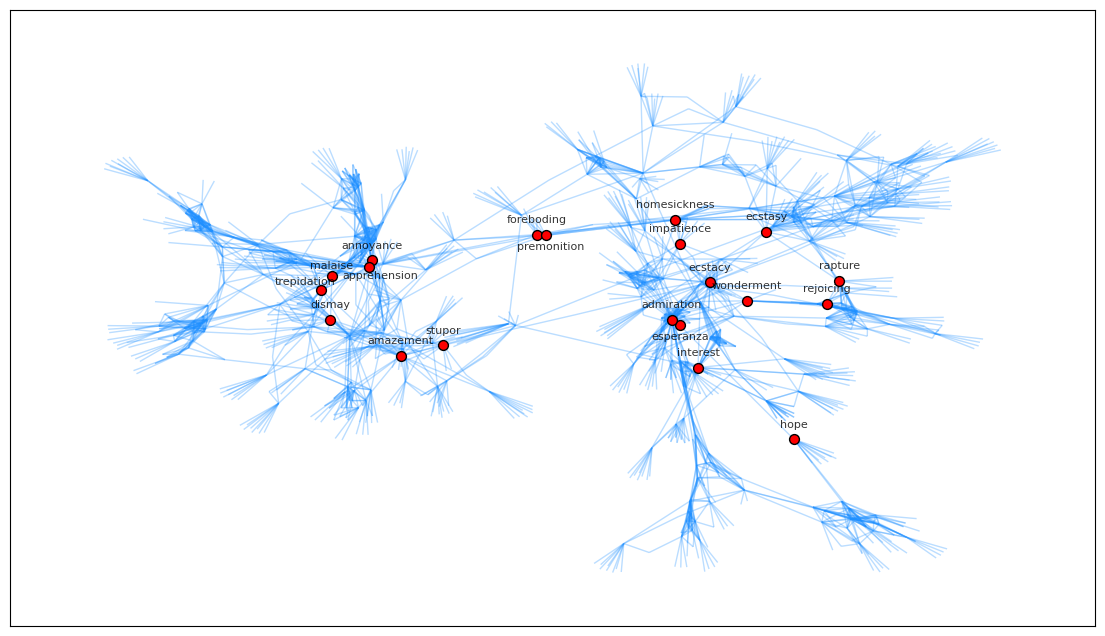

In [172]:
from matplotlib import pyplot as plt
import math

num_to_track = 20
nodes_to_track = betweenness_words[-num_to_track:]
# Huge overlap with plutchhik words in gc (not surprisingly)
#nodes_to_track = dc_words[-num_to_track:]
#nodes_to_track = [word for word in filtered_basic_emotions if word in gc]
print(len(nodes_to_track))
plt.figure(figsize=(14,8))
##############  Do Layout ########################################################
#pos_gc=nx.spring_layout(gc,seed=8) 
##############  Draw Edges ########################################################
nx.draw_networkx_edges(gc,pos_gc, edge_color='dodgerblue',alpha=.3)  
##############  Draw Small Unlabeled Nodes ########################################################
#node_colors = {node:"red" if node in betweenness_words else "blue" for node in gc.nodes}
node_colors = ["red" if node in nodes_to_track else "blue" for node in gc.nodes]
node_size = [50 if node in nodes_to_track else 20 for node in gc.nodes]
#nx.draw_networkx_nodes(gc,pos_gc,node_color='blue',node_size=20)#,edge_color="k") 
#nx.draw_networkx_nodes(gc,pos_gc,node_color=node_colors,node_size=node_size)#,edge_color="k") 

##############  Draw Large Labeled Nodes ########################################################
# Just draw the nodes to track over the edges
ncoll = nx.draw_networkx_nodes(gc,pos_gc,nodes_to_track,node_color="red",node_size=50)#,edge_color="k") 
#ncoll is a matplotlib path collection
ncoll.set_edgecolor("k")
new_labels = {n:n for n in nodes_to_track}
# yoff: Raise labels so that text bottom is yoff pt above node bottom
yoff = 7
# tweak positioning of node labels
offset_dict = {"premonition":(4,-12),"trepidation":(-12,2),"malaise":(0,4),
               "apprehension":(8,-10), "esperanza":(0,-12)}
#offset_dict = {"apprehension":(0,-10),"annoyance":(0,5),
#               "surprise":(0,-10),"grief":(0,-12),"terror":(0,-12),
#               "rage":(-6,14),"loathing":(12,yoff)}
text = annotate_with_networkx_labels(gc,pos_gc,labels=new_labels,alpha = .8, 
                                     offset_dict = offset_dict,yoff=yoff,
                                      verticalalignment='bottom',fontsize=8)
plt.savefig("AffectVec_betweenness_words.png")

Some agreement with Plutchik's wheel structure, some disagreement.  Apprehension
and distraction are far apart in the picture above, close together
on Plutchik's wheel (below).  Viewing this as a 2D model (polar coords), the radial (intensity) axis looks good:
sadness and grief are close; terror and fear are close; ecstasy and joy are close.

Note: There is only one node shown corresponding to the rage and anger vectors because the two vectors are extremely similar, and have all the same nearest neighbors. Therefore the two nodes
are assigned almost the same position in the layout.

#### Intensity digression

Looking at some intensity pairs, as diagrammed by Plutchik

In [139]:
joy_vec = wvecs[word2idx["joy"]]
ecstasy_vec =  wvecs[word2idx["ecstasy"]]
sadness_vec = wvecs[word2idx["sadness"]]
grief_vec =  wvecs[word2idx["grief"]]
rage_vec = wvecs[word2idx["rage"]]
anger_vec = wvecs[word2idx["anger"]]
furious_vec = wvecs[word2idx["furious"]]
angry_vec = wvecs[word2idx["angry"]]
print(my_cos(joy_vec,ecstasy_vec))
# Intensity not found in norm
print(np.linalg.norm(joy_vec),np.linalg.norm(ecstasy_vec))
# Direction from the less intense vec to the more intense one?
intensity_dir0 = ecstasy_vec-joy_vec
intensity_dir1 = grief_vec-sadness_vec
intensity_dir2 = rage_vec-anger_vec
print(my_cos(intensity_dir0,intensity_dir1))
print(my_cos(intensity_dir1,intensity_dir2))
print(my_cos(intensity_dir0,intensity_dir2))

0.5524664145998397
4.3702337202946016 2.4239746450819157
-0.4488409351947655
0.30208954954015915
-0.08566923706397171


Note the AffectVec vectors for "rage" and "anger" are practically the same, so intensity_dir2 is
pretty close to the 0-vector:

In [141]:
my_cos(rage_vec,anger_vec)

0.9953784816174948

The two lexical vectors pointing in almost exactly the same direction and one is a teensy bit longer than the other:

In [142]:
print(np.linalg.norm(rage_vec),np.linalg.norm(anger_vec))

4.208891535784689 4.309119212785832


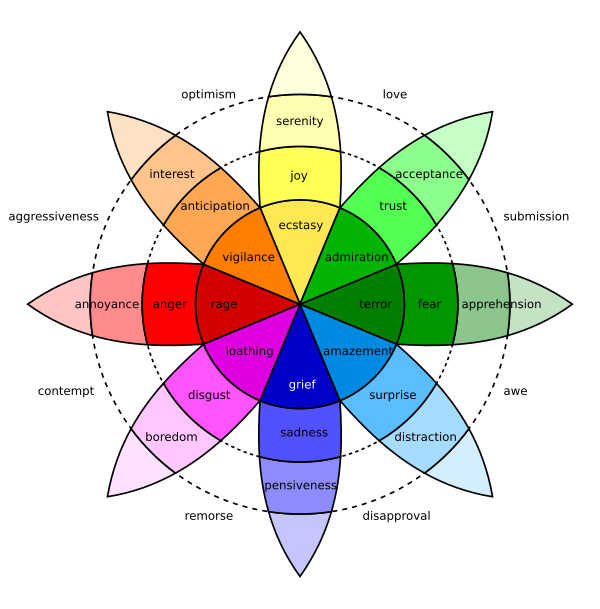

In [120]:
from PIL import Image
from IPython.display import display
img = Image.open('Plutchik-wheel.svg.png')
img

## Recursing from one source word for several generations

Note not sure I've found anything interesting in this experiment.

We choose one of Plutchik's basic emotions, "joy", to illustrate:

In [78]:
g = nx.Graph()
add_nns("joy",g,recurse=3,verbose=True,shrink_fac=1)
                           

g has 100 nodes
g has 200 nodes
g has 200 nodes
g has 200 nodes
g has 300 nodes
g has 300 nodes
g has 400 nodes
g has 400 nodes
g has 400 nodes
g has 400 nodes
g has 400 nodes
g has 400 nodes
g has 400 nodes


In [59]:
g.nodes

NodeView(('joy', 'delight', 'gladness', 'pleasure', 'glee', 'rejoicing', 'rejoice', 'relish', 'delights', 'joys', 'pleasures', 'happiness', 'jubilation', 'cheer', 'merriment', 'mirth', 'cheerfulness', 'excitement', 'thrill', 'jubilant', 'enjoyment', 'satisfaction', 'joyous', 'savor', 'cheerful', 'happy', 'joyful', 'revelry', 'gaiety', 'gleeful', 'wonderment', 'enjoying', 'savoring', 'stardom', 'enjoy', 'experience', 'enjoys', 'happier', 'merry', 'cheery', 'pleased', 'cheerleader', 'festive', 'cheering', 'cheers', 'playful', 'celebratory', 'clapping', 'cheered', 'gioia', 'savour', 'festivity', 'hei', 'joyously', 'farah', 'glory', 'ecstatic', 'brilliance', 'splendor', 'fame', 'luster', 'adore', 'overjoyed', 'exhilarated', 'beaming', 'spontaneity', 'enchantment', 'festivities', 'celebration', 'celebrations', 'glad', 'delighted', 'contented', 'gratified', 'experiences', 'love', 'sex', 'gratification', 'contentment', 'satisfied', 'fulfillment', 'fulfilment', 'experiencing', 'indulge', 'toge

In [80]:
nx.is_connected(g)

True

In [81]:
nx.number_connected_components(g)

1

In [82]:
len(g)

463

A mess:

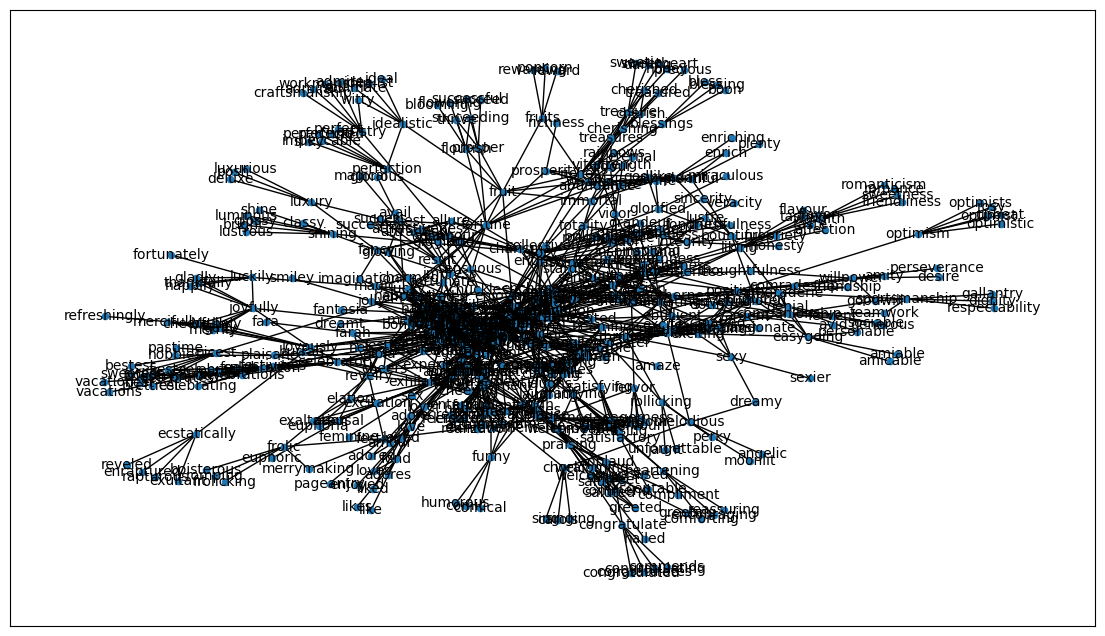

In [209]:
from matplotlib import pyplot as plt
import math

#lg = g.subgraph(first)
lg=g
plt.figure(figsize=(14,8))
pos=nx.spring_layout(lg,seed=8) 
#default_distance_between_nodes = 1.0/(math.sqrt(len(lg.nodes())))
#pos = nx.spring_layout(lm,scale=1.0,k=5*default_distance_between_nodes) # Try adjusting default distance between nodes
# Default node size=300, default font_size=12
# nx.draw_networkx(lm,pos, node_size=300, font_size=12)  
# node_size=800,font_size=8
# Try experimenting with node_shape 'D'
nx.draw_networkx(lg,pos, node_size=20, font_size=10)
node_colors = ["red" if node in nodes_to_track else "blue" for node in gc.nodes]
node_size = [50 if node in nodes_to_track else 20 for node in gc.nodes]


In [ ]:
#new_labels = dict((k,k) for (k,v) in top_chars)
#num_nodes = len(lm.nodes())
#import math
#default_distance_between_nodes = 1.0/(math.sqrt(num_nodes))

In [84]:
#n = 4
#color = pyplot.cm.viridis(np.linspace(0, 1,n))
color = ["Cyan", "Gold", "Violet", "Ivory"]
#rcParams['axes.prop_cycle'] = cycler.cycler(color = color)
def annotate_with_networkx_labels(G, pos,
                                  labels=None,
                                  fontname = None,
                                  fontsize=12,
                                  font_color='k',
                                  font_weight='normal',
                                  alpha=1.0,
                                  ax=None,
                                  horizontalalignment = 'center',
                                  verticalalignment = 'center',
                                  xoff = 0.0,
                                  yoff = 0.0,
                                  offset_dict = None,
                                  **kwds):
    """
    Draw node labels on the graph G.  This functions as a standin for networx.draw_networkx_labels,
    which allows either uniform label offset (xoff,yoff) or node by node label offset (offset_dict).

    Parameters
    ----------
    G : graph
       A networkx graph

    pos : dictionary, optional
       A dictionary with nodes as keys and positions as values.
       If not specified a spring layout positioning will be computed.
       See networkx.layout for functions that compute node positions.

    font_size : int
       Font size for text labels (default=12)

    font_color : string
       Font color string (default='k' black)

    font_weight : string
       Font weight (default='normal')

    xoff: int ot float
        Horizontal offset in points of text from node
        
    yoff: int ot float
        Vertical offset in points of text from node
        
    alpha : float
       The text transparency (default=1.0)

    ax : Matplotlib Axes object, optional
       Draw the graph in the specified Matplotlib axes.
    """
    if ax is None:
        ax=plt.gca()
    if labels is None:
        labels=dict( (n,n) for n in G.nodes())

    # A variant for some of the text annotations.
    text_props_r = dict(fontname =fontname,
                        size=fontsize,
                        color= font_color,
                        weight = font_weight,
                        verticalalignment = verticalalignment,
                        horizontalalignment = horizontalalignment,
                        alpha = alpha,
                        # Express text coords in offsets from xy, unit is pt
                        textcoords='offset points')

    text_items={}  # there is no text collection so we'll fake one
    offset_dict0 = dict((n,(xoff,yoff)) for n in G)
    if offset_dict:
        offset_dict0.update(offset_dict)
    for n, label in labels.items():
        (x,y)=pos[n]
        label=str(label) # this will cause "1" and 1 to be labeled the same
        thisxoff,thisyoff = offset_dict0[n]
        t=ax.annotate(label,xy=(x, y),
                      xytext=(thisxoff,thisyoff),
                      #transform = ax.transData,
                      clip_on=True,
                      **text_props_r
                      )
        text_items[n]=t

    return text_items

In [210]:
lm = g
threshhold = 2
iters,iters_bd = 0,1
while iters < iters_bd:
    new_g_nodes = [n for (n,d) in dict(nx.degree(lm)).items() if d > threshhold]
    lm = lm.subgraph(new_g_nodes)
    iters += 1
    
new_labels= {k:k for k in lm.nodes}

lm has only thos nodes of g whose degree is higher tan 2

In [211]:
len(g),len(lm)

(463, 274)

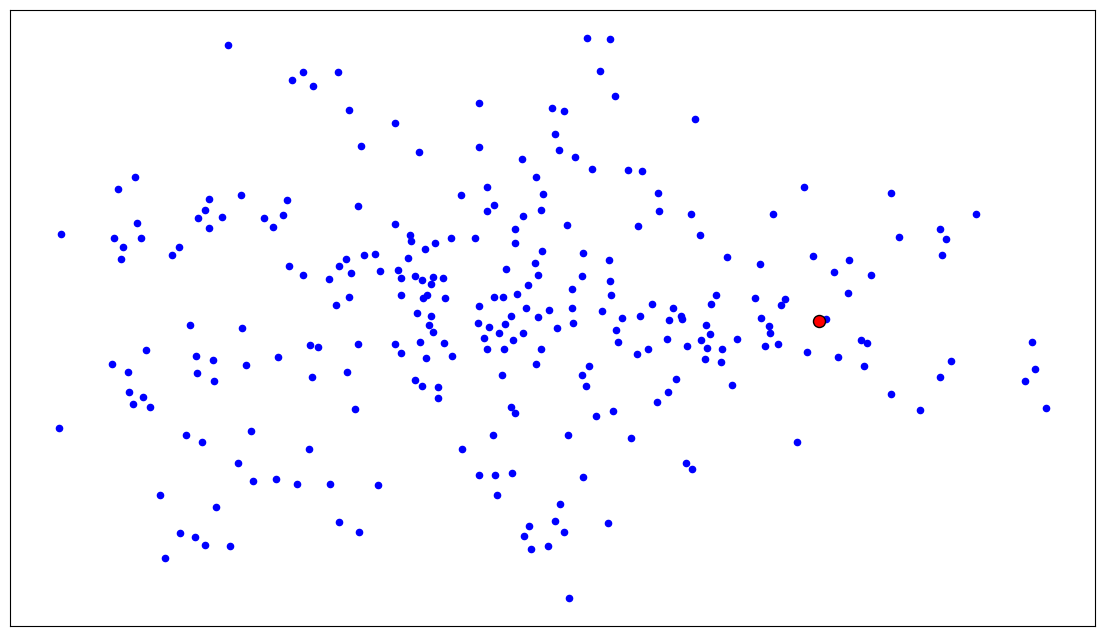

In [192]:

plt.figure(figsize=(14,8))
##############  Do Layout ########################################################
pos_lm=nx.spring_layout(lm,seed=8) 
##############  Draw Edges ########################################################
#nx.draw_networkx_edges(lm,pos, edge_color='blue',alpha=.3)  
##############  Draw Small Unlabeled Nodes ########################################################
nx.draw_networkx_nodes(lm,pos,node_color='blue',node_size=20)#,edge_color="k") 
ncoll = nx.draw_networkx_nodes(gc,pos_gc,["joy"],node_color="red",node_size=75)#,edge_color="k") 
#ncoll is a matplotlib path collection
ncoll.set_edgecolor("k")
##############  Draw Large Labeled Nodes ########################################################
#ncoll= nx.draw_networkx_nodes(lm,pos,new_labels,node_color='red',node_size=200)
## Add outline to large nodes only
#ncoll.set_edgecolor('black')
# yoff: Raise labels so that text bottom is 9 pt above node bottom
#yoff=7
yoff=3
#text = annotate_with_networkx_labels(lm,pos,labels=new_labels,yoff=yoff, alpha = .8, 
#                                     verticalalignment='bottom',fontsize=8)
#plt.savefig("AffectVec_joy_words.png")

## Using other renderers (and by the way, pygraphviz)

Save a `.dot` file by using code buried in a pretty remote corner of `networkx`, for 
using graphviz for visualing.

In [194]:
import networkx as nx
nx.drawing.nx_agraph.write_dot(lm, "AffectVec_joy_words.dot")

This enables gephi to be brought to bear.  Presumably also cytoscape.

In [212]:
nx.write_graphml(lm, "AffectVec_joy_words.graphml")

In [15]:
nx.write_graphml(g, "AffectVec_plutchik_words.graphml")

Frankly the recommended route from here is just to start using graphviz or gephi from the commandline.  This
gives access to a broader set of layout algorithms and various hooks for tweaking their
    output.  All `pygraphviz` gives access to is neato and dot, neither of which give very good
results for this particular 274-node graph.  On the other hand, I got pretty good results with this graph using
the graphviz implemnetation of the layout algorithm `fdp` with node shape `plaintext` and edge style `invis`.

That result is better than what's described next, which involves installing `pygraphviz`.

Install pygrapghiz

```
conda install --channel conda-forge pygraphviz
```

NB This uses the conda `conda-forge` channel rather than the default, as recommended by
[the Pygrpgviz tutorial.](https://pygraphviz.github.io/documentation/stable/install.html)

Pygraphviz can read dit  files, among other formats:

In [200]:
import pygraphviz as pgv
G = pgv.AGraph("AffectVec_joy_words.dot")  

Now it can use `dot` to layout the graph and write it a `.png` file.  The following works and is ugly

In [196]:
G.layout(prog="dot")
# Directly turns the layout into  .png image, creates the file.
G.draw("AffectVec_joy_words2.png")

This is medium-size graph (274 nodes) and frankly the results were not good.  But this was
due to `dot` not `pygraphviz`.  Using `dot` from the commandline (I have an installed version
of `graphviz`) yielded an identical layout, that is, ugly.

Takes a long time and who needs a circular layout anyhoo?

In [199]:
#G = pgv.AGraph("AffectVec_joy_words.dot") 
#print("Beginning layout")
#G.layout(prog="circo")
#print("Layout done")
#G.draw("AffectVec_joy_words4.png")